In [367]:
# Installing requirements
# %pip install -r requirements.txt

In [368]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
sns.set_style("whitegrid")

In [369]:
df = pd.read_csv("recipe_site_traffic_2212.csv")

In [370]:
# Size of dataset
df.shape

(947, 8)

In [371]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data Validation


In [372]:
# Drop the id column
df.drop(columns=["recipe"], inplace=True)

## Checking data types


In [373]:
# Checking data types
df.dtypes

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

The `high_traffic` needs to be converted to an integer


In [374]:
# Replace null with "0"
df["high_traffic"] = df["high_traffic"].fillna("0")
# Replace "High" with "1"
df["high_traffic"] = df["high_traffic"].replace("High", "1")
# COnvert to int
df["high_traffic"] = pd.to_numeric(df["high_traffic"]).astype(int)

`high_traffic` column is now suitable for modelling


In [375]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,NaN,NaN,NaN,NaN,Pork,6,1
1,35.48,38.56,0.66,0.92,Potato,4,1
2,914.28,42.68,3.09,2.88,Breakfast,1,0
3,97.03,30.56,38.63,0.02,Beverages,4,1
4,27.05,1.85,0.80,0.53,Beverages,4,0


## Handling missing values


In [376]:
# Percentage of missing values
round(df.isna().sum() / len(df) * 100, 3)

calories        5.491
carbohydrate    5.491
sugar           5.491
protein         5.491
category        0.000
servings        0.000
high_traffic    0.000
dtype: float64

It appears that `calories`, `carbohydrate`, `sugar`, `protein` always miss together

My strategy to fill in null values

1. Split rows based on `category`
2. Plot distributions of columns above to determine what measure of central tendency will be used to impute i.e mean, mode, median.

-   Plotting is to check for _skew_ and _modality_

3. Impute accordingly


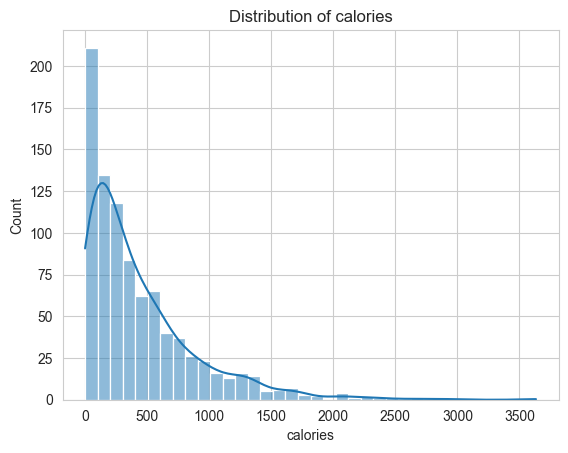

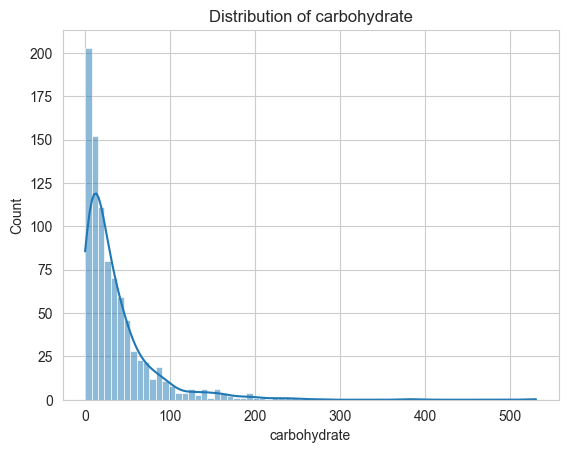

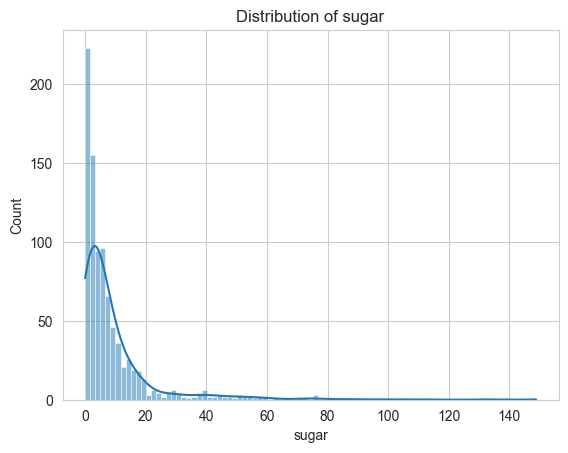

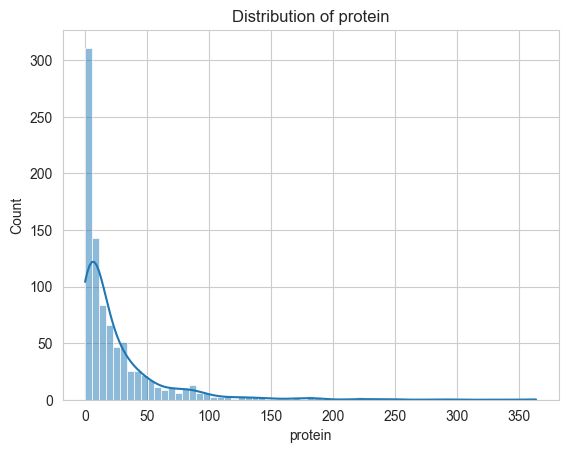

In [377]:
columns_with_missing_values = ["calories", "carbohydrate", "sugar", "protein"]

for column in columns_with_missing_values:
    sns.histplot(x=df[column], kde=True)
    plt.title(f"Distribution of {column}")
    plt.show()

Data is left skewed for all food categories


In [378]:
for column in columns_with_missing_values:
    df[column] = df[column].fillna(df[column].median())

The median shall be used for imputation


## Handling duplicate values


In [379]:
df.duplicated().sum()

np.int64(23)

There are duplicate values. This is caused by the imputation above.


In [380]:
df.drop_duplicates(inplace=True, keep="first")

In [381]:
df.duplicated().sum()

np.int64(0)

Duplicate values removed


## Checking class imbalance


In [382]:
df["high_traffic"].value_counts(normalize=True).round(3)

high_traffic
1    0.601
0    0.399
Name: proportion, dtype: float64

Data is fairly balanced


# Exploratory Analysis


## Check distributions of categorical columns


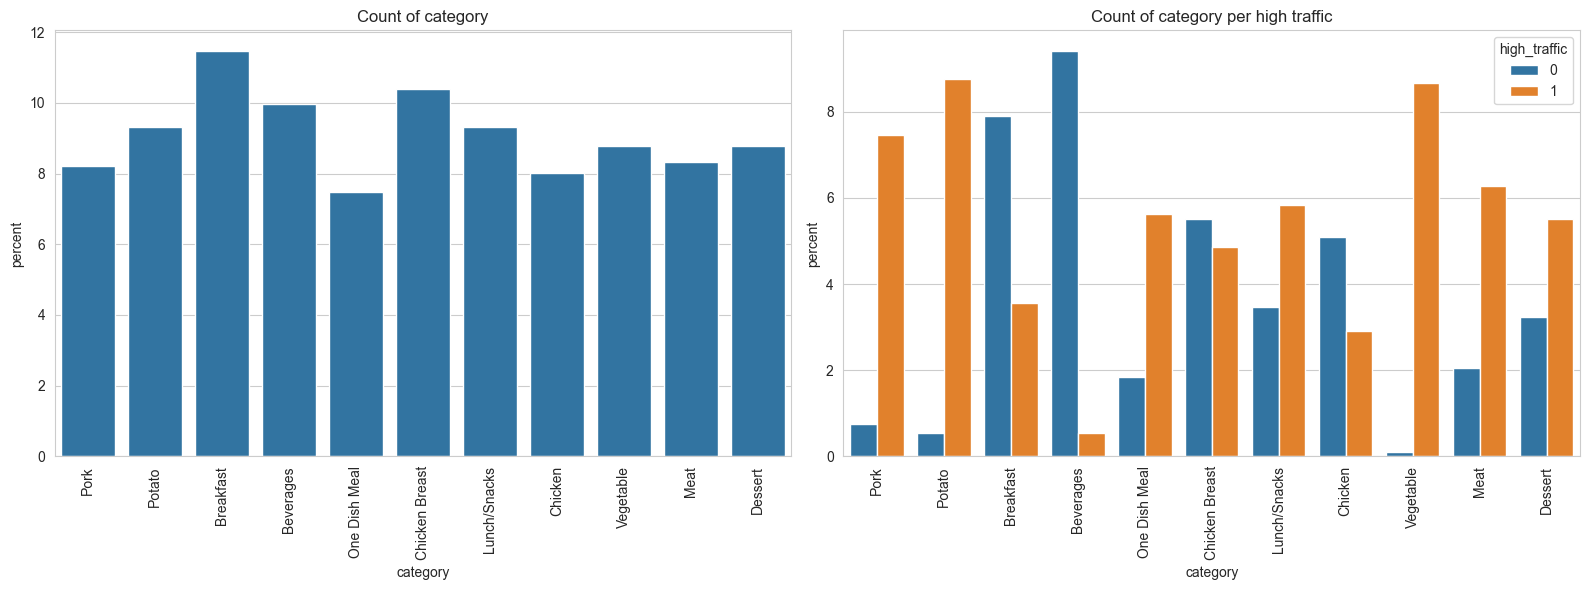

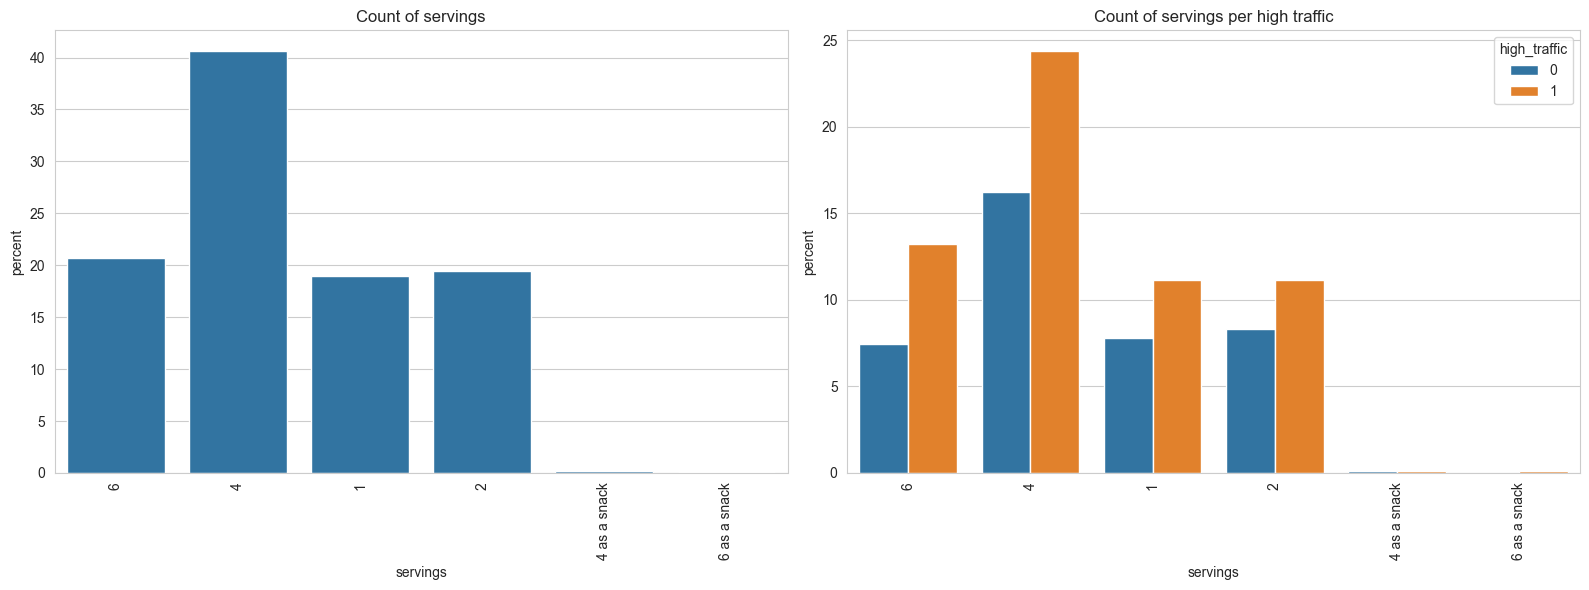

In [383]:
categorical_columns = df.select_dtypes(include=["object"]).columns.to_list()
categorical_columns_df = df.loc[:, categorical_columns]

categorical_columns_df.loc[:, "high_traffic"] = df.loc[:, "high_traffic"]

for column in categorical_columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.countplot(ax=axes[0], x=categorical_columns_df[column], stat="percent")
    axes[0].set_title(f"Count of {column}")
    axes[0].tick_params(axis="x", labelrotation=90)

    sns.countplot(
        ax=axes[1],
        x=categorical_columns_df[column],
        hue=df["high_traffic"],
        stat="percent",
    )

    axes[1].set_title(f"Count of {column} per high traffic")
    axes[1].tick_params(axis="x", labelrotation=90)

    plt.tight_layout()
    plt.show()

### Summary: Checking distributions of categorical columns

1. For the column `category`:

-   Values with high traffic

    -   pork
    -   potato
    -   vegetable
    -   meat

-   Values with low traffic
    -   beverages
    -   breakfast

2. For the column `servings`, the value do not well distinguish if a value for a column is either going to be high or low traffic


## Checking distributions of numerical columns


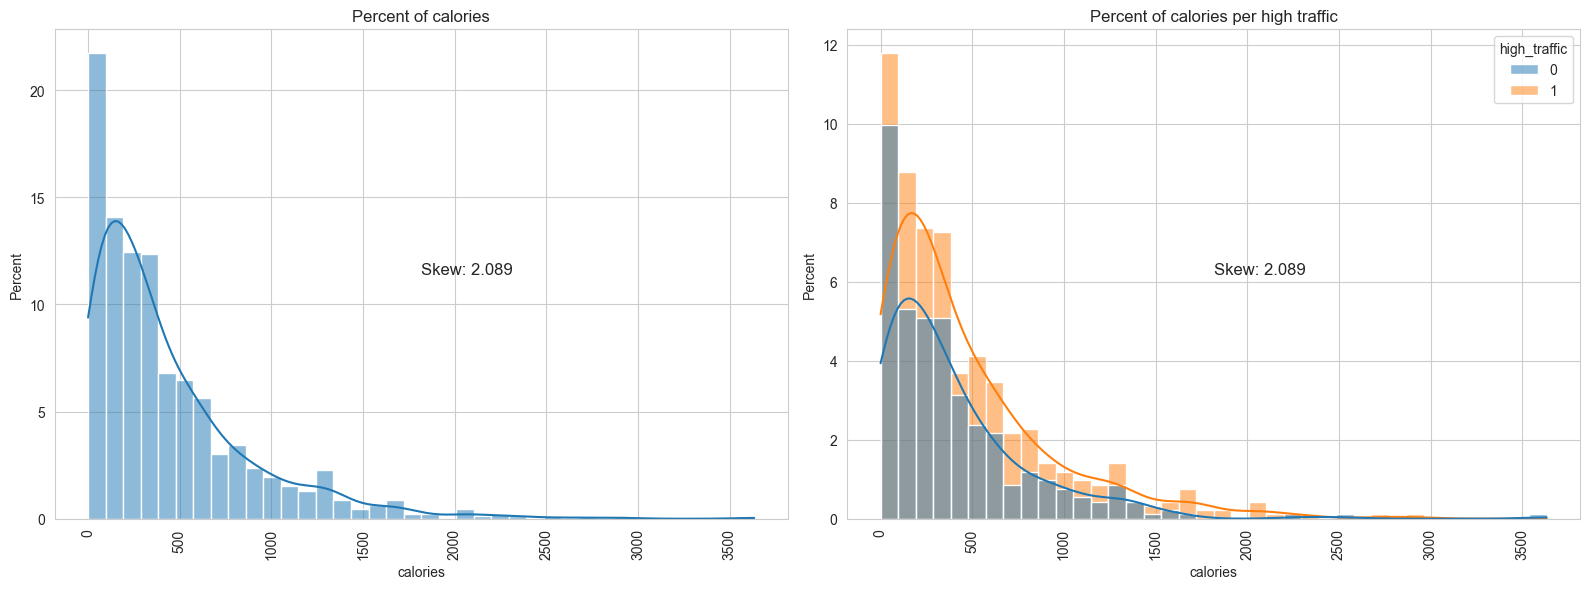

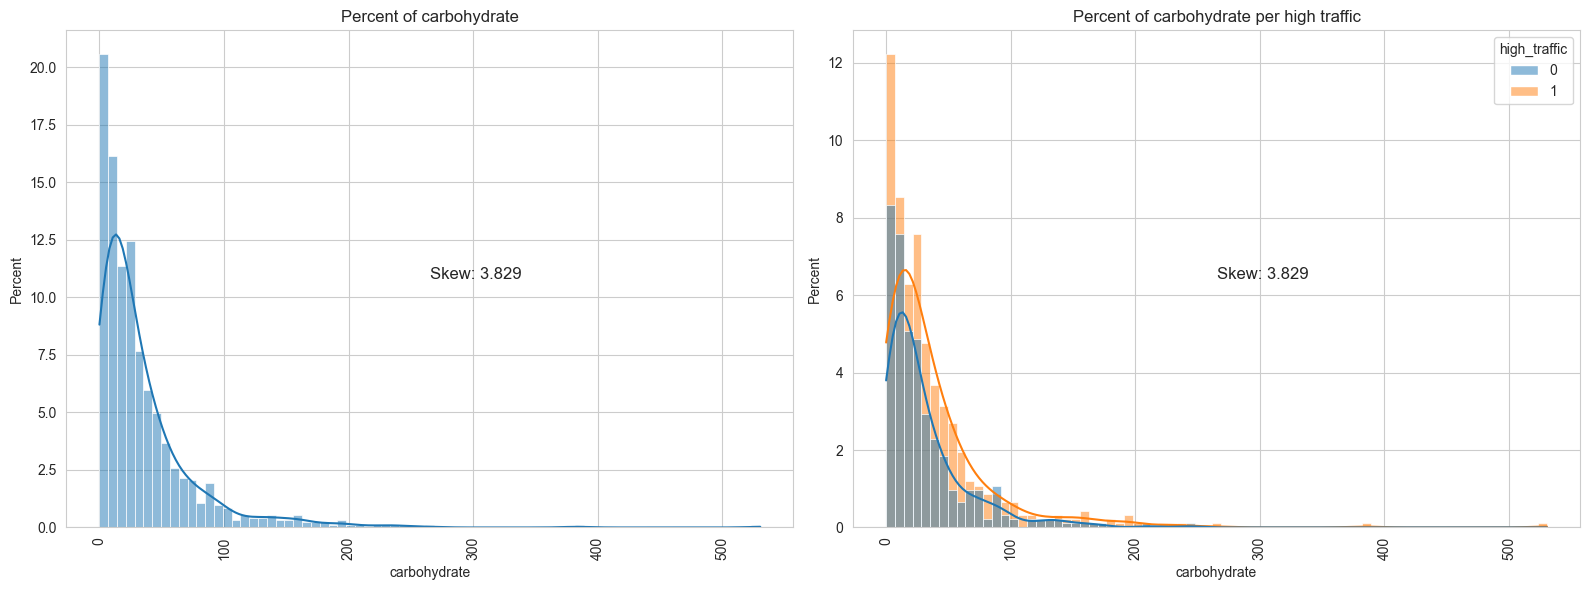

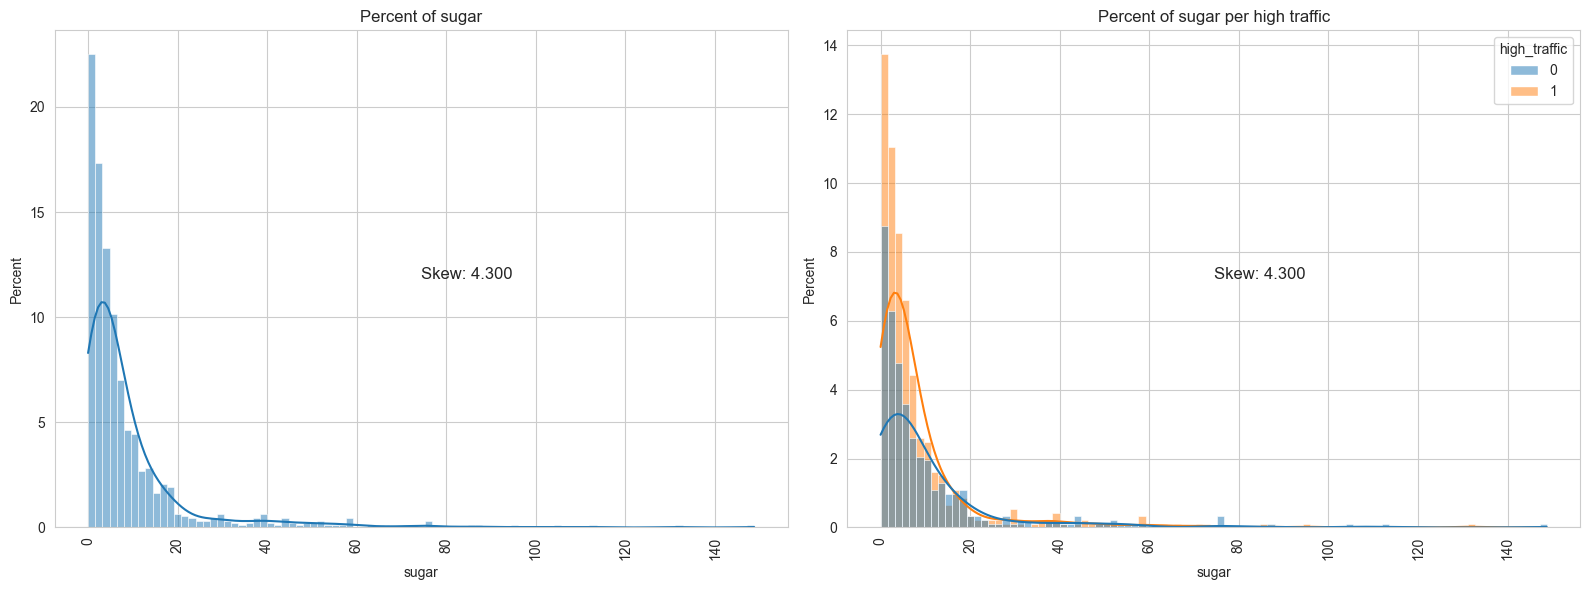

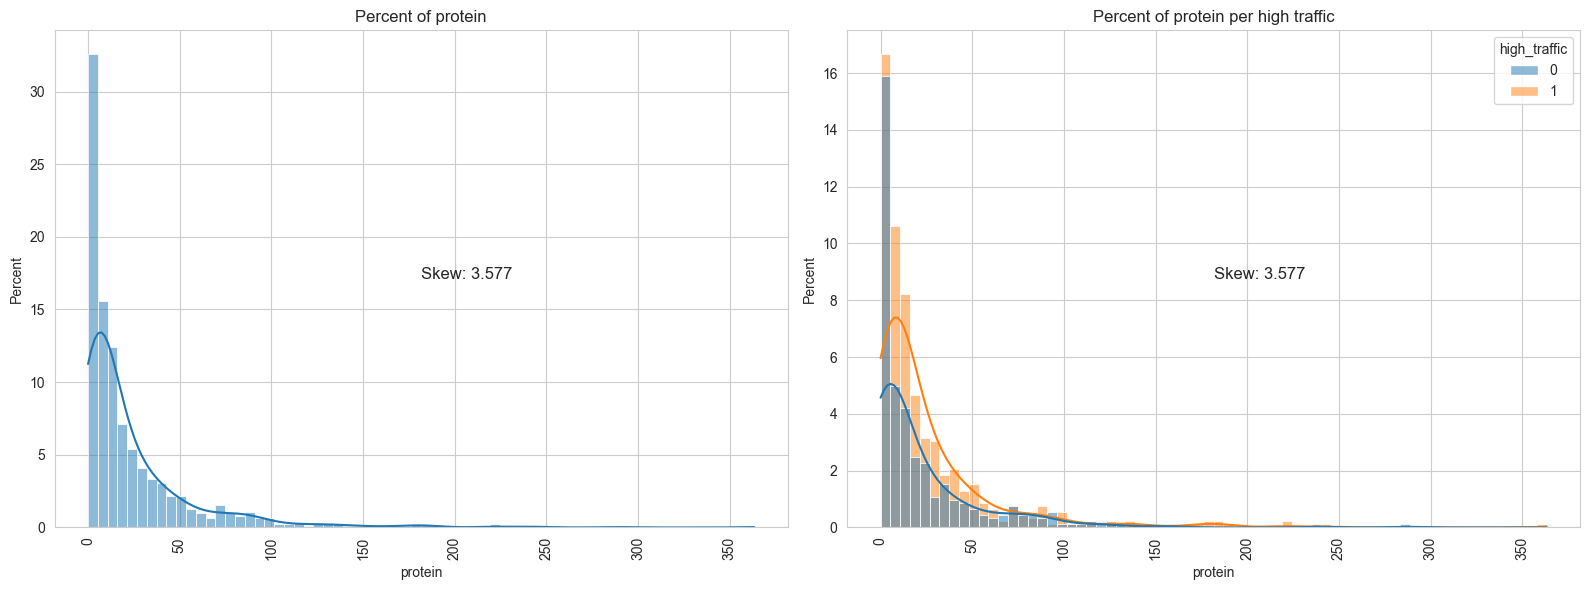

In [384]:
numerical_columns = df.select_dtypes(include=["float64"]).columns
numerical_columns_df = df.loc[:, numerical_columns]
numerical_columns_df.loc[:, "high_traffic"] = df.loc[:, "high_traffic"]

for column in numerical_columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(ax=axes[0], x=numerical_columns_df[column], kde=True, stat="percent")
    skew = numerical_columns_df[column].skew()
    axes[0].set_title(f"Percent of {column}")
    axes[0].tick_params(axis="x", labelrotation=90)
    axes[0].text(
        0.5, 0.5, f"Skew: {skew:.3f}", transform=axes[0].transAxes, fontsize=12
    )
    sns.histplot(
        ax=axes[1],
        x=numerical_columns_df[column],
        hue=df["high_traffic"],
        kde=True,
        stat="percent",
    )

    axes[1].set_title(f"Percent of {column} per high traffic")
    axes[1].tick_params(axis="x", labelrotation=90)
    axes[1].text(
        0.5, 0.5, f"Skew: {skew:.3f}", transform=axes[1].transAxes, fontsize=12
    )

    plt.tight_layout()
    plt.show()

### Summary: Checking distribution of numerical columns

All numerical columns have a positive skew, data transformation shall be done


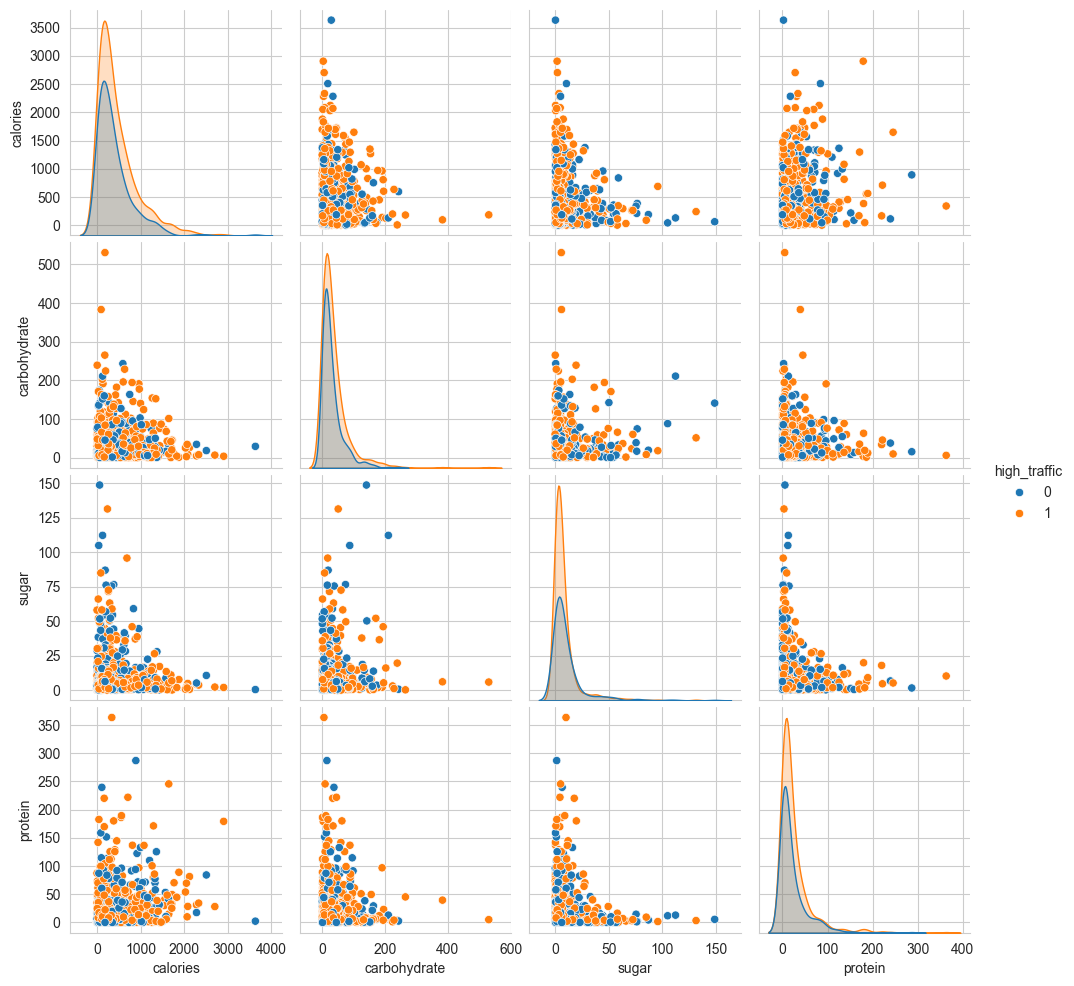

In [385]:
pairplot_columns = numerical_columns.to_list()
pairplot_columns.append("high_traffic")

sns.pairplot(
    data=df,
    hue="high_traffic",
)

plt.show()

No column pair well distinguishes the `high_traffic` class


# Model Development


The problem at hand is a binary classification problem.

The model is to predict if a recipe will introduce high or low traffic to the website


## Fitting a Base Model


In [386]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

X = df.drop(columns=["high_traffic"])
y = df["high_traffic"]

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(
    X, y, test_size=0.2, random_state=42
)

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train_dummy, y_train_dummy)

DummyClassifier(strategy='most_frequent')

## Fitting a Comparison Model


### Encoding categorical columns(Frequency encoding)


In [387]:
from sklearn.preprocessing import StandardScaler

high_traffic_df = df[df["high_traffic"] == 1]

encoded_categorical_columns = []
proportion_dicts = {}
reverse_proportion_dicts = {}

for column in categorical_columns:
    column_proportions = high_traffic_df[column].value_counts(normalize=True).round(3)

    # print(f"{column_proportions=}")
    proportion_df = column_proportions.reset_index()
    proportion_df.columns = [column, "proportion"]

    scaler = StandardScaler()

    proportion_df["proportion_standardized"] = scaler.fit_transform(
        proportion_df[["proportion"]]
    )

    proportion_dict = proportion_df.set_index(column)[
        "proportion_standardized"
    ].to_dict()

    proportion_dicts[column] = proportion_dict
    reverse_proportion_dicts[column] = {v: k for k, v in proportion_dict.items()}

    print(column)
    print(proportion_dict)
    print()

    encoded_categorical_column = f"{column}_encoded"

    encoded_categorical_columns.append(encoded_categorical_column)

    df[encoded_categorical_column] = df[column].map(proportion_dict)

df.head()
df.drop(columns=categorical_columns, inplace=True)

categorical_columns = encoded_categorical_columns

category
{'Potato': 1.4106533546085354, 'Vegetable': 1.3594415166524498, 'Pork': 0.8473231370915956, 'Meat': 0.36081067650878373, 'Lunch/Snacks': 0.15596332468444207, 'One Dish Meal': 0.07914556775031382, 'Dessert': 0.027933729794228326, 'Chicken Breast': -0.2537313789642416, 'Breakfast': -0.8170615964811817, 'Chicken': -1.0731207862616088, 'Beverages': -2.097357545383318}

servings
{'4': 1.7231268312510712, '6': 0.38465882377123295, '2': 0.13867010888304648, '1': 0.13867010888304648, '4 as a snack': -1.1925629363941979, '6 as a snack': -1.1925629363941979}



In [388]:
# from sklearn.preprocessing import LabelEncoder
# # Frequency encoding shall be used due to high cardinality of the categorical columns
# label_encoders = dict()
# for column in categorical_columns:
#     label_encoder = LabelEncoder()
#     df[f"{column}_encoded"] = label_encoder.fit_transform(df[column])
#     label_encoders[column] = label_encoder
# df = df.drop(columns=categorical_columns)

### Transforming numerical columns


In [389]:
standardized_columns = []


for column in numerical_columns:
    standardized_column = f"log_{column}"
    standardized_columns.append(standardized_column)
    df[standardized_column] = df[column].apply(lambda x: np.log1p(x))

df.drop(columns=numerical_columns, inplace=True)
numerical_columns = standardized_columns

df.head()

,high_traffic,category_encoded,servings_encoded,log_calories,log_carbohydrate,log_sugar,log_protein
0,1,0.847323,0.384659,5.668328,3.112626,1.713798,2.468100
1,1,1.410653,1.723127,3.596764,3.677819,0.506818,0.652325
2,0,-0.817062,0.138670,6.819230,3.776890,1.408545,1.355835
3,1,-2.097358,1.723127,4.585274,3.451890,3.679586,0.019803
4,0,-2.097358,1.723127,3.333989,1.047319,0.587787,0.425268


### Scaling numerical columns


In [390]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


df.head()

,high_traffic,category_encoded,servings_encoded,log_calories,log_carbohydrate,log_sugar,log_protein
0,1,0.847323,0.384659,0.000000,0.000000,0.000000,0.000000
1,1,1.410653,1.723127,-1.272839,0.375178,-0.893353,-0.935449
2,0,-0.817062,0.138670,0.707153,0.440942,-0.225935,-0.573015
3,1,-2.097358,1.723127,-0.665465,0.225206,1.454989,-1.261311
4,0,-2.097358,1.723127,-1.434297,-1.370963,-0.833424,-1.052424


### Handling redundant features


In [391]:
print(df.head())

correlation_matrix_columns = df.columns.to_list()
correlation_matrix_columns.remove("high_traffic")

df[correlation_matrix_columns].corr()

   high_traffic  category_encoded  servings_encoded  log_calories  \
0             1          0.847323          0.384659      0.000000   
1             1          1.410653          1.723127     -1.272839   
2             0         -0.817062          0.138670      0.707153   
3             1         -2.097358          1.723127     -0.665465   
4             0         -2.097358          1.723127     -1.434297   

   log_carbohydrate  log_sugar  log_protein  
0          0.000000   0.000000     0.000000  
1          0.375178  -0.893353    -0.935449  
2          0.440942  -0.225935    -0.573015  
3          0.225206   1.454989    -1.261311  
4         -1.370963  -0.833424    -1.052424  


,category_encoded,servings_encoded,log_calories,log_carbohydrate,log_sugar,log_protein
category_encoded,1.000000,0.055072,0.107885,0.129418,-0.140289,0.201596
servings_encoded,0.055072,1.000000,-0.031652,0.001368,0.013580,0.011860
log_calories,0.107885,-0.031652,1.000000,-0.029002,-0.073735,0.188410
log_carbohydrate,0.129418,0.001368,-0.029002,1.000000,0.013420,0.039963
log_sugar,-0.140289,0.013580,-0.073735,0.013420,1.000000,-0.119572
log_protein,0.201596,0.011860,0.188410,0.039963,-0.119572,1.000000


No features are redundant. All features shall be kept


### Feature Selection


In [392]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

X = df.drop(columns=["high_traffic"])
y = df["high_traffic"]

rf_classifier = RandomForestClassifier(
    criterion="gini",
    min_samples_split=40,
    random_state=42,
    n_jobs=-1,
    ccp_alpha=0.015,
)

rfe = RFECV(
    estimator=rf_classifier,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    n_jobs=-1,
)
rfe.fit(X, y)

print("RFE done...")
print()
# Get the optimal number of features
print("Optimal number of features: %d" % rfe.n_features_)
print()

selected_features = []
print("Selected features")
print("=================")
for i, col in zip(range(X.shape[1]), X.columns):
    if rfe.support_[i]:
        selected_features.append(col)
        print(f"Column: {col}, Rank: {rfe.ranking_[i]}, Selected: {rfe.support_[i]}")

print()
print("Not selected features")
print("=====================")
for i, col in zip(range(X.shape[1]), X.columns):
    if not rfe.support_[i]:
        print(f"Column: {col}, Rank: {rfe.ranking_[i]}, Selected: {rfe.support_[i]}")

df = pd.concat([df[selected_features], df["high_traffic"]], axis=1)
# Refreshing numerical columns in preparation for PCA
numerical_columns = df.select_dtypes(include=["float64"]).columns

RFE done...

Optimal number of features: 1

Selected features
Column: category_encoded, Rank: 1, Selected: True

Not selected features
Column: servings_encoded, Rank: 6, Selected: False
Column: log_calories, Rank: 4, Selected: False
Column: log_carbohydrate, Rank: 5, Selected: False
Column: log_sugar, Rank: 3, Selected: False
Column: log_protein, Rank: 2, Selected: False


Only `category_encoded` is chosen.


## Fitting comparison model


In [393]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression

X = df.drop(columns=["high_traffic"])
y = df["high_traffic"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

knn = KNeighborsClassifier()
knn_param_grid = {
    "n_neighbors": range(1, 31),
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

# log_reg = LogisticRegression(random_state=42, solver="liblinear", max_iter=10000)
# log_reg_param_grid = {
#     "C": [0.000000001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
#     "penalty": ["l1", "l2"],
# }

estimator = knn
param_grid = knn_param_grid

search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X=X_train, y=y_train)

comparison_model = search.best_estimator_

print("Best parameters for comparison model:")
print("-" * 20)
pprint(search.best_params_)
print()

Best parameters for comparison model:
--------------------
{'algorithm': 'auto',
 'metric': 'euclidean',
 'n_neighbors': 20,
 'weights': 'uniform'}



In [394]:
# # Create a DataFrame for actual vs predicted values
# results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# # Plot the distribution of predicted labels for each actual category
# plt.figure(figsize=(10, 6))
# sns.countplot(x='Actual', hue='Predicted', data=results_df, palette='viridis')
# plt.title('Distribution of Predicted Labels for Each Actual Category')
# plt.xlabel('Actual Category')
# plt.ylabel('Count')
# plt.legend(title='Predicted', loc='upper right')
# plt.show()

# Model Evaluation


In [395]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    root_mean_squared_error,
)

y_pred_dummy = baseline_model.predict(X_test_dummy)
y_pred = comparison_model.predict(X_test)


print("Accuracy")
print("-" * 30)
print("Baseline:", round(accuracy_score(y_test_dummy, y_pred_dummy), 3))
print("Comparison:", round(accuracy_score(y_test, y_pred), 3))
print()

print("Classification report")
print("-" * 30)
print("Baseline\n", classification_report(y_test_dummy, y_pred_dummy, zero_division=0))
print(
    "Comparison\n", classification_report(y_true=y_test, y_pred=y_pred, zero_division=0)
)
print()

print("Confusion matrix")
print("-" * 30)
print("Baseline\n", confusion_matrix(y_test_dummy, y_pred_dummy))
print("Comparison\n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print()

print("RSME")
print("-" * 30)
print("Baseline\n", round(root_mean_squared_error(y_test_dummy, y_pred_dummy), 3))
print("Comparison\n", round(root_mean_squared_error(y_true=y_test, y_pred=y_pred), 3))
print()

Accuracy
------------------------------
Baseline: 0.649
Comparison: 0.806

Classification report
------------------------------
Baseline
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.65      1.00      0.79       120

    accuracy                           0.65       185
   macro avg       0.32      0.50      0.39       185
weighted avg       0.42      0.65      0.51       185

Comparison
               precision    recall  f1-score   support

           0       0.76      0.75      0.75       111
           1       0.83      0.84      0.84       167

    accuracy                           0.81       278
   macro avg       0.80      0.80      0.80       278
weighted avg       0.81      0.81      0.81       278


Confusion matrix
------------------------------
Baseline
 [[  0  65]
 [  0 120]]
Comparison
 [[ 83  28]
 [ 26 141]]

RSME
------------------------------
Baseline
 0.593
Comparison
 0.441



# Definition of metric for business to monitor


In [399]:
# Mesh grid
X_test_visual_df = X_test.copy()
X_test_visual_df["actual"] = y_test
X_test_visual_df["predicted"] = y_pred

X_test_visual_df["category"] = df["category_encoded"].map(
    reverse_proportion_dicts["category"]
)

by_category = X_test_visual_df.groupby("category").agg(
    {"actual": "mean", "predicted": "mean"}
)

by_category["actual"] = by_category["actual"].round(2)
by_category

,actual,predicted
category,,
Beverages,0.03,0.0
Breakfast,0.28,0.0
Chicken,0.43,0.0
Chicken Breast,0.35,0.0
Dessert,0.61,1.0
Lunch/Snacks,0.75,1.0
Meat,0.76,1.0
One Dish Meal,0.83,1.0
Pork,0.95,1.0


The percentage of high traffic category for is a metric to look after.

Estimation of intial value of metric: 50% of its traffic being high traffic for it to be called a popular category. (Based on the table above)


# Summary


Choose recipes from categories that have above 50% of its traffic being high traffic
